In [1]:
import pandas as pd
import os 
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

from joblib import Parallel, delayed

In [2]:
# Seleccionar que años se van a tomar en cuenta, discutir esto
years = [str(i) for i in range(1995, 2024)]

datasets = []
for year in years:
    path = os.path.join("dataRaw", "atp_matches_" + year)
    dset = pd.read_csv(path + ".csv")
    datasets.append(dset)

In [3]:
df = pd.concat(datasets)
df = df.reset_index(drop = True)
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1995-339,Adelaide,Hard,32,A,19950102,1,102338,1.0,NaN,...,48.0,31.0,11.0,10.0,11.0,15.0,11.0,NaN,98.0,NaN
1,1995-339,Adelaide,Hard,32,A,19950102,2,101510,NaN,NaN,...,30.0,19.0,9.0,8.0,7.0,11.0,67.0,NaN,51.0,NaN
2,1995-339,Adelaide,Hard,32,A,19950102,3,100837,NaN,NaN,...,48.0,34.0,19.0,15.0,3.0,7.0,77.0,NaN,92.0,NaN
3,1995-339,Adelaide,Hard,32,A,19950102,4,101185,8.0,NaN,...,28.0,21.0,17.0,10.0,3.0,6.0,43.0,NaN,79.0,NaN
4,1995-339,Adelaide,Hard,32,A,19950102,5,101793,3.0,NaN,...,42.0,25.0,11.0,10.0,3.0,7.0,13.0,NaN,70.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89947,2023-M-DC-2023-WG2-PO-RSA-LUX-01,Davis Cup WG2 PO: RSA vs LUX,NaN,4,D,20230204,5,202335,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1717.0,1.0
89948,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,1,117365,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,990.0,11.0,279.0,190.0
89949,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,2,121411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,364.0,131.0,894.0,15.0
89950,2023-M-DC-2023-WG2-PO-TUN-CYP-01,Davis Cup WG2 PO: TUN vs CYP,NaN,4,D,20230203,4,144949,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,894.0,15.0,285.0,184.0


In [4]:
# Selección de features
df.isnull().sum()/len(df)

tourney_id            0.000000
tourney_name          0.000000
surface               0.000589
draw_size             0.000000
tourney_level         0.000000
tourney_date          0.000000
match_num             0.000000
winner_id             0.000000
winner_seed           0.593205
winner_entry          0.876101
winner_name           0.000000
winner_hand           0.000078
winner_ht             0.023879
winner_ioc            0.000000
winner_age            0.000067
loser_id              0.000000
loser_seed            0.775425
loser_entry           0.797347
loser_name            0.000000
loser_hand            0.000467
loser_ht              0.047225
loser_ioc             0.000000
loser_age             0.000122
score                 0.000000
best_of               0.000000
round                 0.000000
minutes               0.116673
w_ace                 0.094384
w_df                  0.094384
w_svpt                0.094384
w_1stIn               0.094384
w_1stWon              0.094384
w_2ndWon

In [5]:
# Definir técnicas para rellenar datos, pero manteniendo una versión con datos clean.


In [6]:
# Viendo el año, podemos construir un set de testing, el siguiente número es el procentaje
# del tamaño del testing en comparación al total.

len(df[df["tourney_date"] < 20150101])/len(df)

0.7265652792600498

In [7]:
len(df[(df["tourney_date"] >= 20150101) & (df["tourney_date"] <= 20181231)])/len(df)

0.13092538242618285

In [8]:
len(df[df["tourney_date"] > 20190101])/len(df)

0.14250933831376733

### Que hacer para el avance 

- Decidir un espacio de tiempo, junto a que features a utilizar y como tratar los datos faltantes. XXX
- Tratar features cualitativos. XXX
- Detección de features altamente correlacionados.
- Detección de outliers.
- Definición del set de testeo, por posible problema de dependencia temporal.
- Selección de modelos de clasificación a probar para predicción de resultados.

### Definir el dataset

- Se usará los partidos del 2000 a 2017 como training.
- Se usaran los datos de 2024 como validación.
- Se usará los partidos del 2018 a 2023 como testing.


In [9]:
df.isnull().sum()/len(df)

tourney_id            0.000000
tourney_name          0.000000
surface               0.000589
draw_size             0.000000
tourney_level         0.000000
tourney_date          0.000000
match_num             0.000000
winner_id             0.000000
winner_seed           0.593205
winner_entry          0.876101
winner_name           0.000000
winner_hand           0.000078
winner_ht             0.023879
winner_ioc            0.000000
winner_age            0.000067
loser_id              0.000000
loser_seed            0.775425
loser_entry           0.797347
loser_name            0.000000
loser_hand            0.000467
loser_ht              0.047225
loser_ioc             0.000000
loser_age             0.000122
score                 0.000000
best_of               0.000000
round                 0.000000
minutes               0.116673
w_ace                 0.094384
w_df                  0.094384
w_svpt                0.094384
w_1stIn               0.094384
w_1stWon              0.094384
w_2ndWon

### No eliminar data, puesto que vamos a usar promedios.

<Axes: >

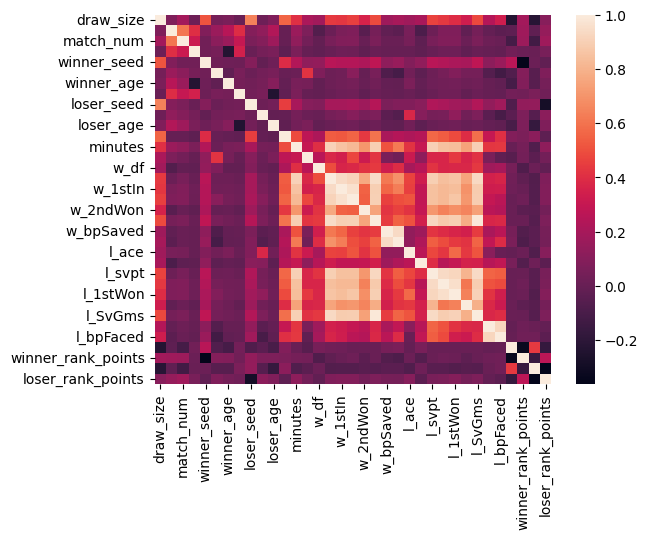

In [10]:
cuantitative_variables_names = df.select_dtypes(["float","int"]).columns.tolist()
df_corr = df[cuantitative_variables_names].corr()
sns.heatmap(df_corr, cmap = "rocket")

In [11]:
# Features a usar

featuresNoEntrenables = ["winner_seed", "winner_entry", "loser_seed", "loser_entry"
                       "minutes", "round", "score", "tourney_id", "tourney_name"
                       "draw_size", "tourney_level", "tourney_date", "match_num",
                       "winner_name","loser_name"]

featuresDelMatch = ["surface", "winner_hand", "loser_hand", "winner_age",
                    "loser_age", "best_of","tourney_date"]

# best_of debe ser categorico

# featuresDeMatchPasados = #NUMERICOS


In [14]:
### Recopilar información de los n partidos hacia atras de cada jugador.
def pastInfo(df, num_matches, i):

    # Para la búsqueda de features
    prefixes = ['winner_', "w_"]
    filtered_columns_winner = [col for col in df.columns if any(col.startswith(prefix) for prefix in prefixes)]

    prefixes = ['loser_', "l_"]
    filtered_columns_loser = [col for col in df.columns if any(col.startswith(prefix) for prefix in prefixes)]
    
    # Solo partidos del 2000 en adelante
    if df.iloc[i]["tourney_date"] < 20000101:
        return pd.DataFrame()
    winner_name = df.iloc[i].winner_name
    loser_name = df.iloc[i].loser_name

    # Partidos del ganador

    dfAux = deepcopy(df.iloc[:i])
    dfAux = dfAux[(dfAux.loser_name == winner_name)| (dfAux.winner_name == winner_name)].sort_values(by=["tourney_date"], ignore_index=True)[-num_matches:]
    dataWinner = []
    for j in range(len(dfAux)):

        if dfAux.iloc[j].winner_name == winner_name:
            filterDrop = dfAux.iloc[j][filtered_columns_winner].drop(["winner_hand","winner_age", "winner_ioc", "winner_name","winner_entry","winner_id","winner_seed"], axis = 0)
            data = pd.DataFrame(filterDrop).T
            newColumns = data.columns.str.replace(r'^(winner_|w_)', 'player1_', regex=True)
            data.columns = newColumns
            dataWinner.append(data)

        elif dfAux.iloc[j].loser_name == winner_name:
            filterDrop = dfAux.iloc[j][filtered_columns_loser].drop(["loser_hand","loser_age", "loser_ioc", "loser_name","loser_entry","loser_id","loser_seed"], axis = 0)
            data = pd.DataFrame(filterDrop).T
            newColumns = data.columns.str.replace(r'^(loser_|l_)', 'player1_', regex=True)
            data.columns = newColumns
            dataWinner.append(data)

    # Partidos del perdedor

    dfAux = deepcopy(df.iloc[:i])
    dfAux = dfAux[(dfAux.loser_name == loser_name)| (dfAux.winner_name == loser_name)].sort_values(by=["tourney_date"], ignore_index=True)[-num_matches:]
    dataLoser = []
    for j in range(len(dfAux)):
        
        if dfAux.iloc[j].winner_name == loser_name:
            filterDrop = dfAux.iloc[j][filtered_columns_winner].drop(["winner_hand","winner_age", "winner_ioc", "winner_name","winner_entry","winner_id","winner_seed"], axis = 0)
            data = pd.DataFrame(filterDrop).T
            newColumns = data.columns.str.replace(r'^(winner_|w_)', 'player2_', regex=True)
            data.columns = newColumns
            dataLoser.append(data)

        elif dfAux.iloc[j].loser_name == loser_name:
            filterDrop = dfAux.iloc[j][filtered_columns_loser].drop(["loser_hand","loser_age", "loser_ioc", "loser_name","loser_entry","loser_id","loser_seed"], axis = 0)
            data = pd.DataFrame(filterDrop).T
            newColumns = data.columns.str.replace(r'^(loser_|l_)', 'player2_', regex=True)
            data.columns = newColumns
            dataLoser.append(data)
    # Si no hay información suficiente del partido, pasar  OJO DECIDIR ESTO BIEN DESPUES################
    if len(dataWinner) == 0 or len(dataLoser) == 0:
        return pd.DataFrame()
    dataWinner = pd.concat(dataWinner).mean().to_frame().T
    dataLoser = pd.concat(dataLoser).mean().to_frame().T


    dfAux = deepcopy(df.iloc[:i])
    dfAuxWinnerWin = dfAux[(dfAux.winner_name == winner_name)]
    dfAuxWinnerLoss = dfAux[(dfAux.loser_name == winner_name)]
    dfAuxLoserWin = dfAux[(dfAux.winner_name == loser_name)]
    dfAuxLoserLoss = dfAux[(dfAux.loser_name == loser_name)]

    # Partidos ganados/perdidos por tipo de suelo
    superficies = df["surface"].unique()
    for suelo in superficies:
        dataWinner[f"player1_Wins_On_{suelo}"] = len(dfAuxWinnerWin[dfAuxWinnerWin.surface == suelo])
        dataWinner[f"player1_Loss_On_{suelo}"] = len(dfAuxWinnerLoss[(dfAuxWinnerLoss.surface == suelo)])
        dataLoser[f"player2_Wins_On_{suelo}"] = len(dfAuxLoserWin[dfAuxLoserWin.surface == suelo])
        dataLoser[f"player2_Loss_On_{suelo}"] = len(dfAuxLoserLoss[(dfAuxLoserLoss.surface == suelo)])
    
    # Partidos ganados/perdidos por tipo de mano
    manos = df["winner_hand"].unique()
    for mano in manos:
        dataWinner[f"player1_Wins_On_{mano}"] = len(dfAuxWinnerWin[dfAuxWinnerWin.loser_hand == mano])
        dataWinner[f"player1_Loss_On_{mano}"] = len(dfAuxWinnerLoss[(dfAuxWinnerLoss.winner_hand == mano)])
        dataLoser[f"player2_Wins_On_{mano}"] = len(dfAuxLoserWin[dfAuxLoserWin.loser_hand == mano])
        dataLoser[f"player2_Loss_On_{mano}"] = len(dfAuxLoserLoss[(dfAuxLoserLoss.winner_hand == mano)])

    dataMatch = pd.DataFrame(df.iloc[i][featuresDelMatch]).T.reset_index(drop=True)
    dataMatch.rename(columns={'winner_hand': 'player1_hand', "loser_hand": "player2_hand",
                            "winner_age":"player1_age", "loser_age": "player2_age"}, inplace=True)
    
    dataFinal = pd.concat([dataMatch, dataWinner, dataLoser], axis = 1)
    dataFinal["label"] = 0
    dataFinal["index"] = i # Para poder identificar los datasets
    return dataFinal

In [15]:
# Búsqueda serial
nums = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
for num_matches in nums:
    resultado = []
    for i in tqdm(range(len(df))):
        resultado.append(pastInfo(df, num_matches, i))
    dfTotal = pd.concat(resultado, axis = 0)
    dfTotal.to_csv(f"Datasets\{num_matches}MeanPastMatches.csv")

 21%|██▏       | 19190/89952 [00:44<02:43, 431.92it/s] 


KeyboardInterrupt: 

In [16]:
# Duplicarlos:
nums = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for num_matches in nums:
    file = pd.read_csv(f"Datasets/{num_matches}MeanPastMatches.csv")
    file = file.drop("Unnamed: 0", axis = 1)
    # file.rename(columns={"player2_hand.1":"player2_age"}, inplace=True)

    new_file = pd.DataFrame()

    # Copiar la columna surface, la fecha, el label, la duración y el index para identificarlo.
    new_file["surface"] = file["surface"]
    new_file["tourney_date"] = file["tourney_date"]
    new_file["label"] = 1
    new_file["best_of"] = file["best_of"]
    new_file["index"] = file["index"]

    columnas_intercambiables = ["hand","age", "ht", "ace", "df", "svpt", "1stIn", "1stWon", "2ndWon", "SvGms", "bpSaved", "bpFaced", "rank", "rank_points"]

    superficies = df["surface"].unique()
    manos = df["winner_hand"].unique()
    
    for suelo in superficies:
        columnas_intercambiables.append(f"Wins_On_{suelo}")
        columnas_intercambiables.append(f"Loss_On_{suelo}")
    for mano in manos:
        columnas_intercambiables.append(f"Wins_On_{mano}")
        columnas_intercambiables.append(f"Loss_On_{mano}")
        
    
    for columna in columnas_intercambiables:
        nueva_columna_player1 = "player1_" + columna
        nueva_columna_player2 = "player2_" + columna
        new_file[nueva_columna_player2] = file[nueva_columna_player1]
        new_file[nueva_columna_player1] = file[nueva_columna_player2]

    # Si necesitas guardar el nuevo DataFrame en un archivo CSV
    full = pd.merge(left= file, right = new_file, how="outer" )

    full.to_csv(f'duplicatedDatasets/Duplicated{num_matches}MeanPastMatches.csv', index=False)